# Problem definiton
**Segmentation of gliomas in pre-operative MRI scans.**

*Each pixel on image must be labeled:*
* Pixel is part of a tumor area (1 or 2 or 3) -> can be one of multiple classes / sub-regions
* Anything else -> pixel is not on a tumor region (0)

The sub-regions of tumor considered for evaluation are: 1) the "enhancing tumor" (ET), 2) the "tumor core" (TC), and 3) the "whole tumor" (WT)
The provided segmentation labels have values of 1 for NCR & NET, 2 for ED, 4 for ET, and 0 for everything else.In this notebook I am segmenting the Tumor core subregion.

Feel free to drop your suggestions at: sourjyamukherjee261@gmail.com



![Brats official annotations](https://www.med.upenn.edu/cbica/assets/user-content/images/BraTS/brats-tumor-subregions.jpg)

In [2]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt



# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing

np.set_printoptions(precision=3, suppress=True)

In [3]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include


scaler = MinMaxScaler()

In [4]:
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_002/BraTS20_Training_002_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_002/BraTS20_Training_002_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_002/BraTS20_Training_002_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_002/BraTS20_Training_002_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_002/BraTS20_Training_002_seg.nii').get_fdata()


In [5]:
print(test_image_flair.shape)
print(test_image_t1.shape)
print(test_image_t1ce.shape)
print(test_image_t2.shape)


(240, 240, 155)
(240, 240, 155)
(240, 240, 155)
(240, 240, 155)


In [6]:
IMG_SIZE = 128

Text(0.5, 1.0, 'Enhancing_tumor')

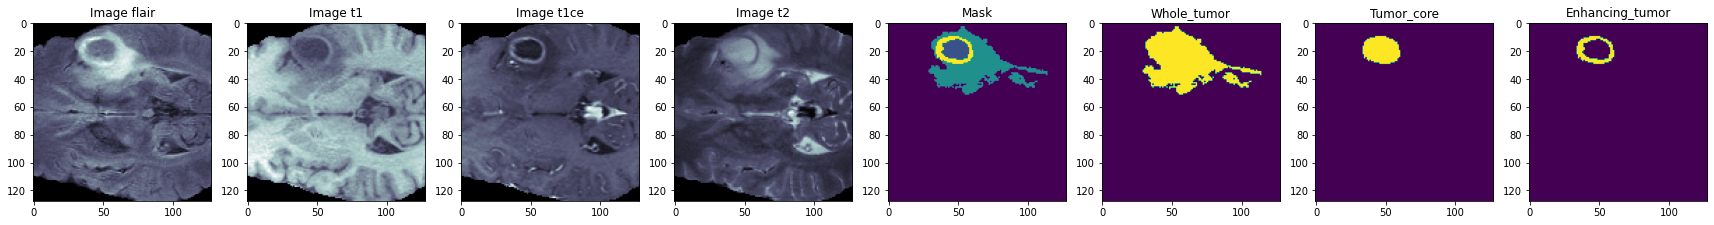

In [6]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(1,8, figsize = (30, 30))
slice_w = 56
ax1.imshow(test_image_flair[56:184,56:184,test_image_flair.shape[0]//2-slice_w], cmap = 'bone')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[56:184,56:184,test_image_t1.shape[0]//2-slice_w], cmap = 'bone')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[56:184,56:184,test_image_t1ce.shape[0]//2-slice_w], cmap = 'bone')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[56:184,56:184,test_image_t2.shape[0]//2-slice_w], cmap = 'bone')
ax4.set_title('Image t2')



wt = test_mask.copy()
wt[wt != 0]=1

et = test_mask.copy()
et[et!=4]=0
et[et!=0]=1

tc = test_mask.copy()
tc[tc == 3]=1
tc[tc != 1]=0
tc = tc + et

ax5.imshow(test_mask[56:184,56:184,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

ax6.imshow(wt[56:184,56:184,test_mask.shape[0]//2-slice_w])
ax6.set_title('Whole_tumor')
ax7.imshow(tc[56:184,56:184,test_mask.shape[0]//2-slice_w])
ax7.set_title('Tumor_core')
ax8.imshow(et[56:184,56:184,test_mask.shape[0]//2-slice_w])
ax8.set_title('Enhancing_tumor')

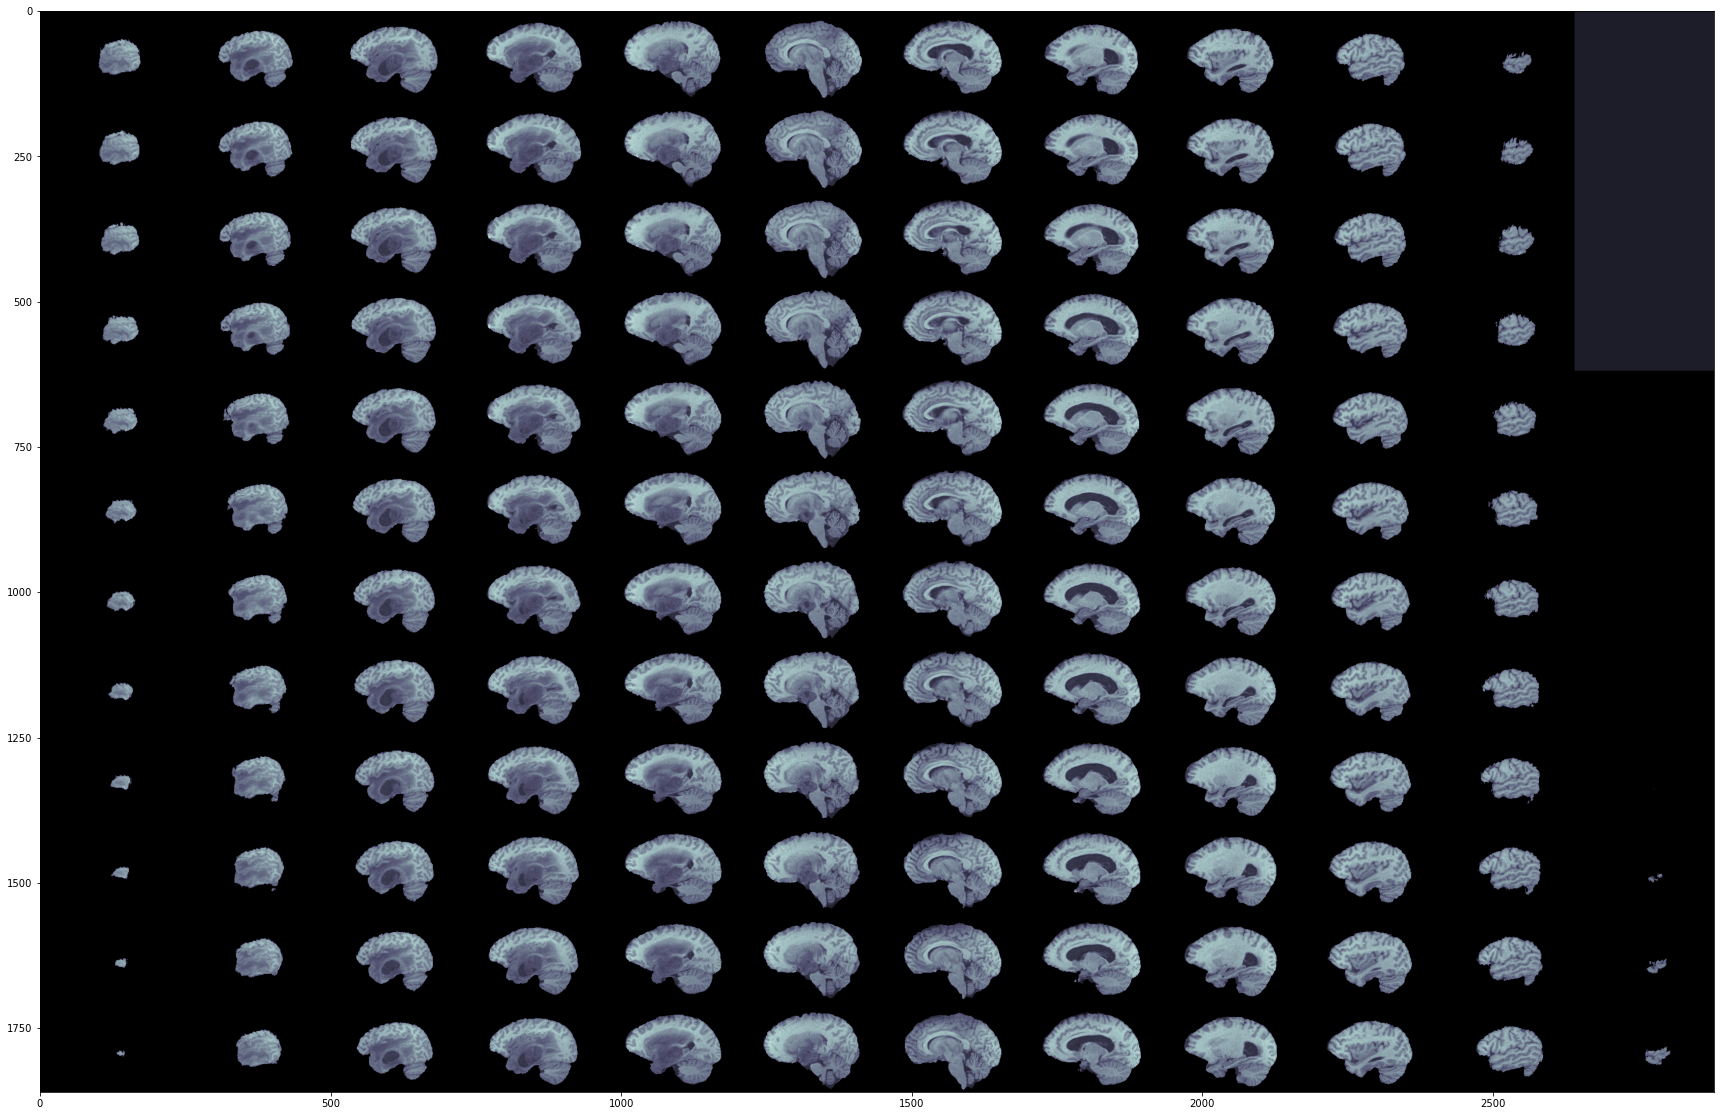

In [9]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (30,30))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='bone')

**Show segment of tumor for each above slice**

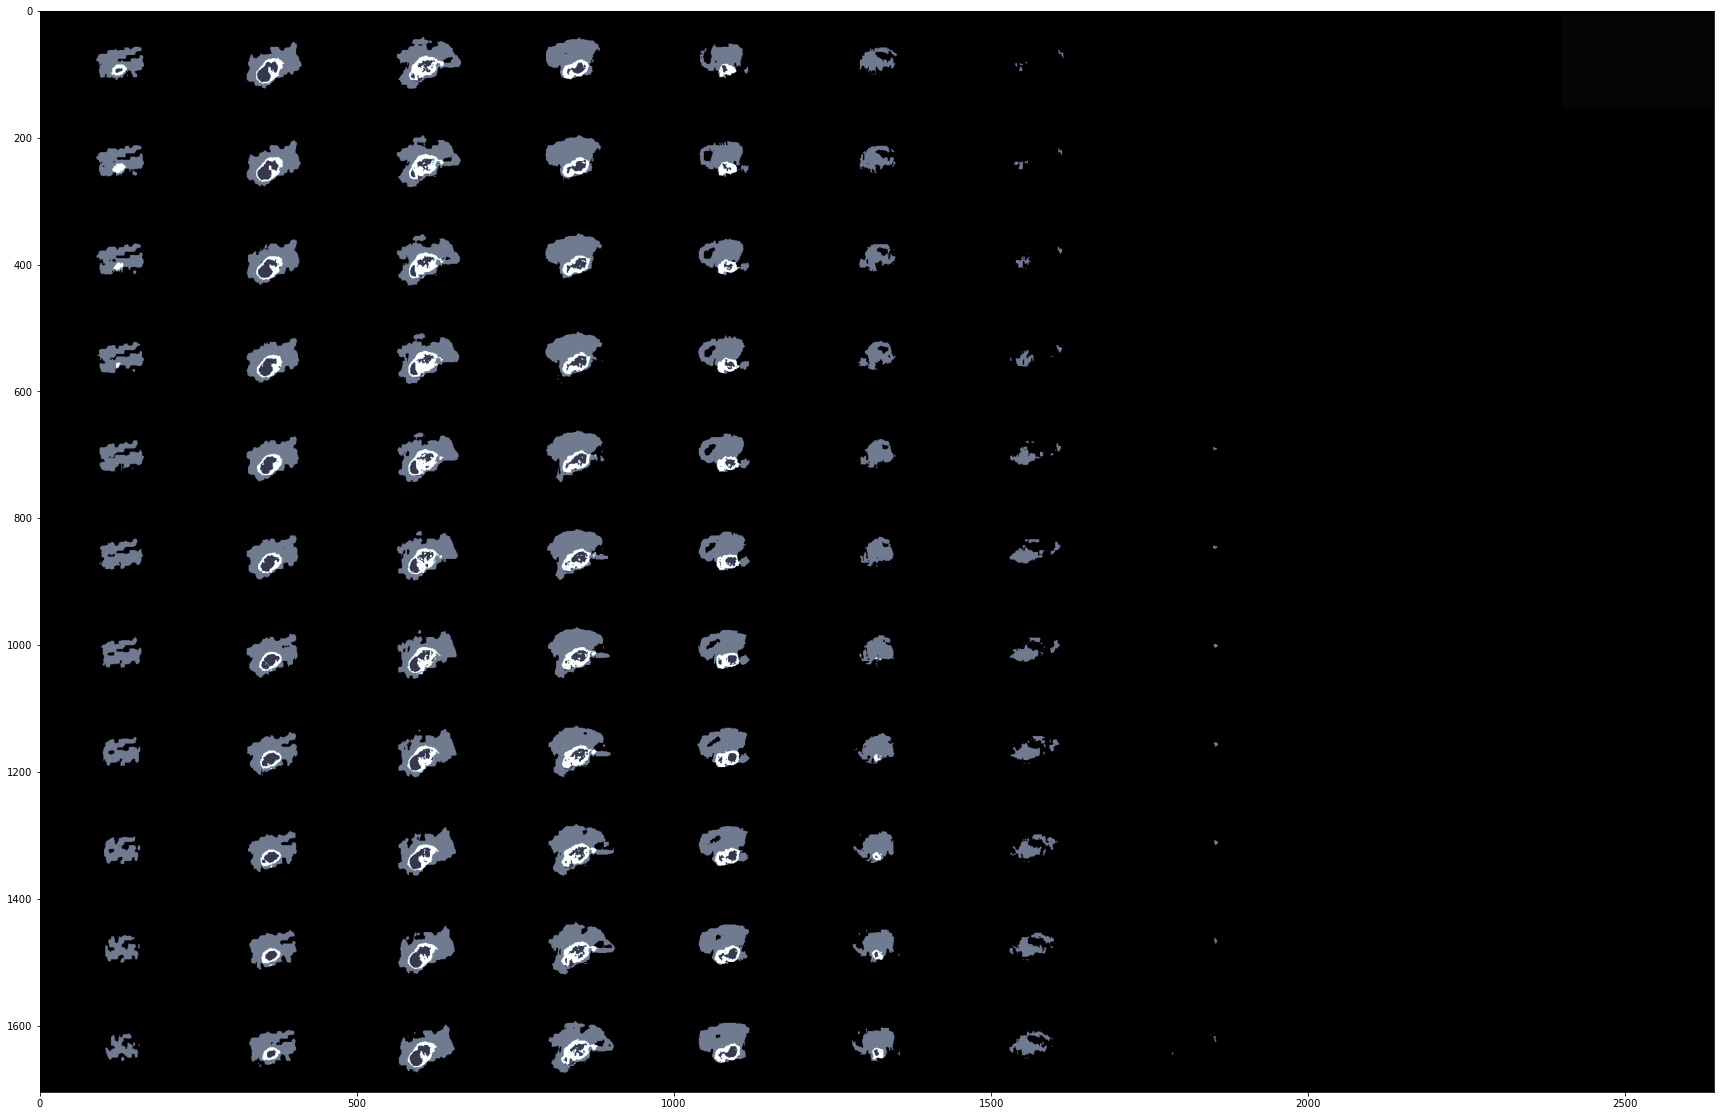

In [15]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (30,30))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='bone')

**Show segments of tumor using different effects**

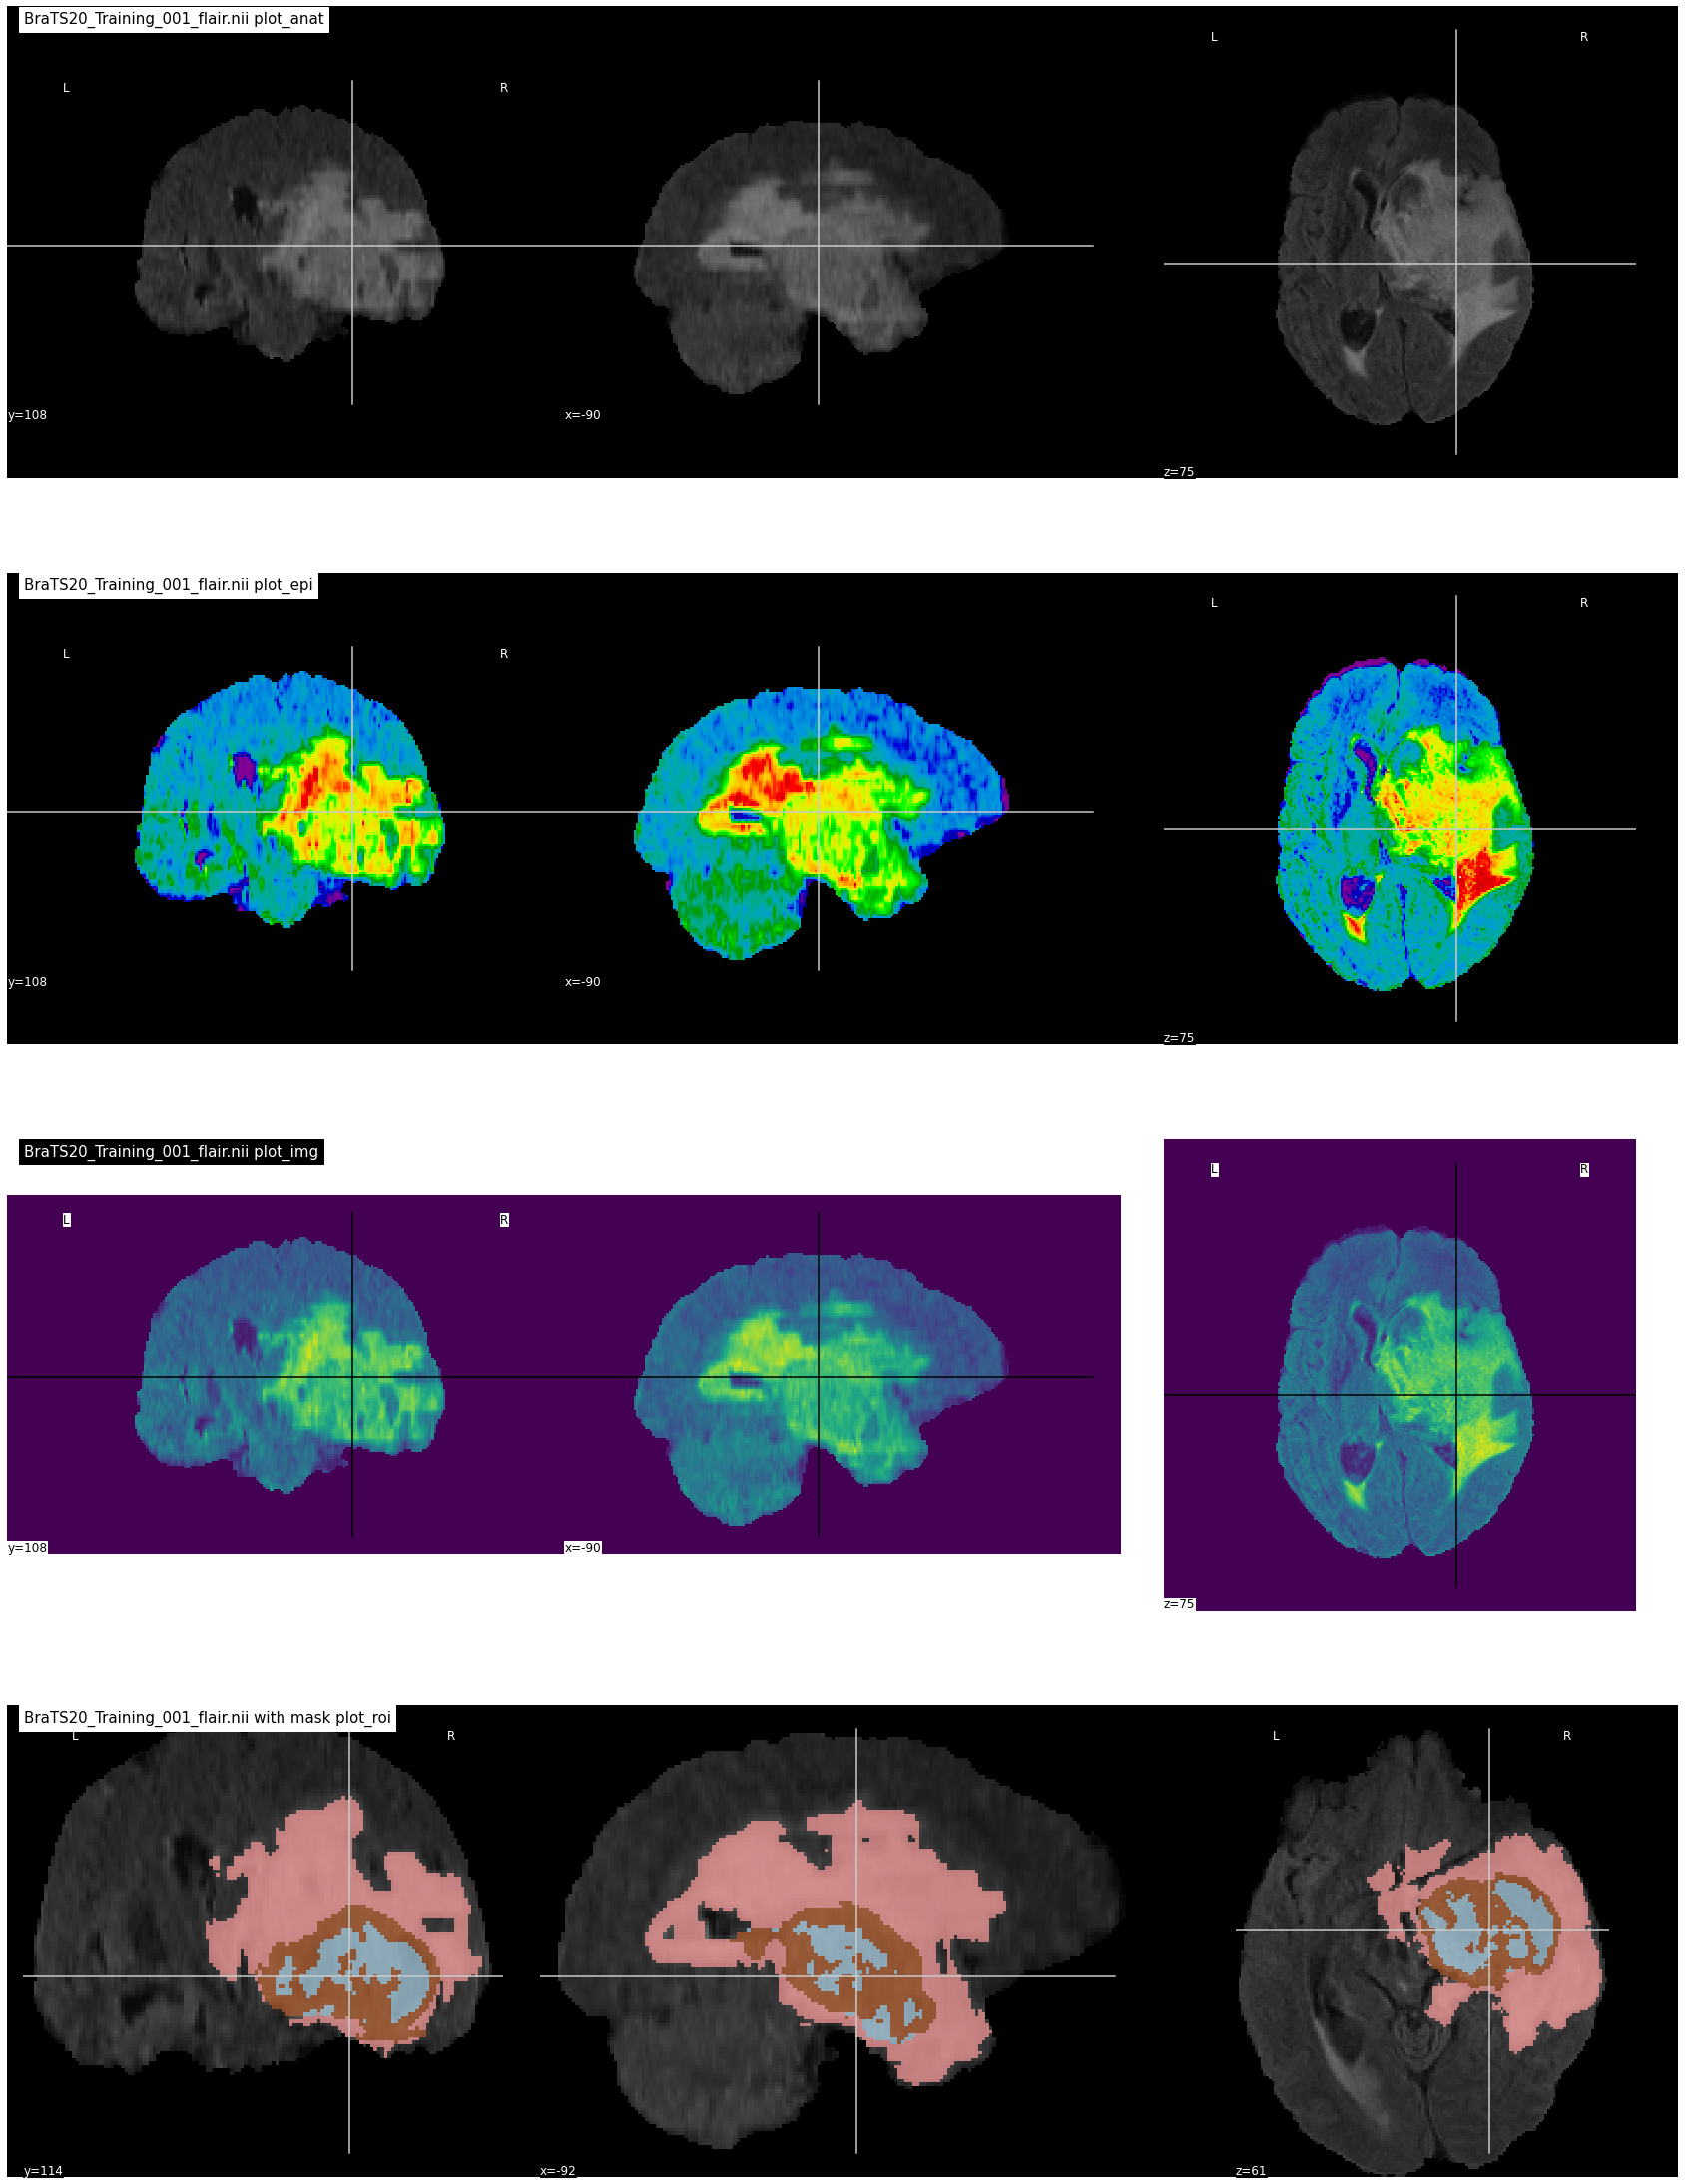

In [16]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS20_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS20_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS20_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS20_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

In [7]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 2
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss


 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_tc(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)



def tversky(y_true, y_pred):
    smooth=1
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return (2 - tversky(y_true[:,:,:,0],y_pred[:,:,:,0])-tversky(y_true[:,:,:,1],y_pred[:,:,:,1]))

def focal_tversky_loss(y_true,y_pred):
    pt_1 = tversky(y_true[:,:,:,0],y_pred[:,:,:,0])
    pt_2 = tversky(y_true[:,:,:,1],y_pred[:,:,:,1])
    gamma = 0.75
    return K.pow((2-pt_1-pt_2), gamma)

# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())


In [8]:
IMG_SIZE=128

In [9]:
!pip install -U segmentation-models
#%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
wt0, wt1 = 0.50,0.50
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.0 MB/s eta 0:00:00
Segmentation Models: using `keras` framework.


In [11]:
from tensorflow.python.keras.optimizers import *

In [12]:
from tensorflow.keras.layers import Conv2D,Conv2DTranspose, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Input, ZeroPadding2D,Dropout,Dense,MaxPooling2D,Reshape,Multiply,GlobalAveragePooling2D,AveragePooling2D
from tensorflow.keras.models import Model

def batchnorm_relu(inputs):
    x = BatchNormalization()(inputs)
    x = Activation("relu")(x)
    return x
def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=3, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=5, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=7, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y
def squeeze_excite_block(inputs, ratio=8):
    init = inputs       ## (b, 128, 128, 32)
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)     ## (b, 32)   -> (b, 1, 1, 32)
    se = Reshape(se_shape)(se)
    se = Dense(filters//ratio, activation="relu", use_bias=False)(se)
    se = Dense(filters, activation="sigmoid", use_bias=False)(se)

    x = Multiply()([inputs, se])
    return x

def residual_block(inputs, num_filters):
    """ Convolutional Layer """
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)
    x = Dropout(0.1)(x)
    x = batchnorm_relu(x)
    x = Conv2D(num_filters, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)
    #x = squeeze_excite_block(x,8)

    """ Shortcut Connection """
    s = Conv2D(num_filters, 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    x = x + s
    return x

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters,2, strides=(2,2), kernel_initializer="he_normal",padding = "same")(inputs)
    x = Concatenate()([x, skip_features])
    x = residual_block(x, num_filters)
    x = squeeze_excite_block(x)
    return x

def build_resunet(input_shape):
    f = [32,64,128,256]
    inputs = Input(input_shape)
    

    """ Encoder 1 """
    x = Conv2D(f[0], 3, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    x = batchnorm_relu(x)
    x = Conv2D(f[0], 3, padding="same", strides=1,kernel_initializer="he_normal")(x)
    s = Conv2D(f[0], 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    
    c1 = x + s
    c1 = squeeze_excite_block(c1)
    p1 = MaxPooling2D((2,2))(c1)
    s1 = residual_block(c1,f[0])

    """ Encoder 2 and 3 """
    c2 = residual_block(p1, f[1])
    c2 = squeeze_excite_block(c2)
    p2 = MaxPooling2D((2,2))(c2)
    s2 = residual_block(c2,f[1])
    
    c3 = residual_block(p2, f[2])
    c3 = squeeze_excite_block(c3)
    p3 = MaxPooling2D((2,2))(c3)
    s3 = residual_block(c3,f[2])

    c4 = residual_block(p3, f[3])
    c4 = squeeze_excite_block(c4)
    p4 = MaxPooling2D((2,2))(c4)
    s4 = residual_block(c4,f[3])

    """ Bridge """
    b = ASPP(p4,128)

    """ Decoder 1, 2, 3 """
    d1 = decoder_block(b, s4, f[3])
    d2 = decoder_block(d1, s3, f[2])
    d3 = decoder_block(d2, s2, f[1])
    d4 = decoder_block(d3, s1, f[0])

    """ Classifier """
    outputs = Conv2D(2, (1,1) , activation="softmax")(d4)

    """ Model """
    model = Model(inputs, outputs)
    return model

model = build_resunet((IMG_SIZE,IMG_SIZE,3))
model.compile(loss=focal_tversky_loss,optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics = ['accuracy',keras.metrics.MeanIoU(num_classes=2),dice_coef,dice_coef_tc, sensitivity, specificity,tversky,tf.keras.metrics.AUC()] )

2023-01-10 20:07:28.103880: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-10 20:07:28.206481: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-10 20:07:28.207320: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-10 20:07:28.209339: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

**model architecture** <br>
If you are about to use U-NET, I suggest to check out this awesome library that I found later, after manual implementation of U-NET [keras-unet-collection](https://pypi.org/project/keras-unet-collection/), which also contains implementation of dice loss, tversky loss and many more!

In [11]:
plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

# Load data
Loading all data into memory is not a good idea since the data are too big to fit in.
So we will create dataGenerators - load data on the fly as explained [here](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)

In [13]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2,random_state=42) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15,random_state=42) 

In [14]:
for i in range (5):
    print(train_ids[i])

BraTS20_Training_272
BraTS20_Training_113
BraTS20_Training_257
BraTS20_Training_040
BraTS20_Training_015


In [16]:
for i in range (5):
    print(test_ids[i])

BraTS20_Training_246
BraTS20_Training_357
BraTS20_Training_242
BraTS20_Training_263
BraTS20_Training_214


**Override Keras sequence DataGenerator class**

In [14]:
class DataGenerator(keras.utils.all_utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 128, 128))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 1))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()
            shape = flair.shape
            flair = scaler.fit_transform(flair.reshape(-1, flair.shape[-1])).reshape(shape)
            flair = flair[56:184,56:184,:]

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()
            shape = ce.shape
            ce = scaler.fit_transform(ce.reshape(-1, ce.shape[-1])).reshape(shape)
            ce = ce[56:184,56:184,:]
            
            
            data_path = os.path.join(case_path, f'{i}_t2.nii');
            t2 = nib.load(data_path).get_fdata()
            shape = t2.shape
            t2 = scaler.fit_transform(t2.reshape(-1, t2.shape[-1])).reshape(shape)
            t2 = t2[56:184,56:184,:]
            
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()
            seg = seg[56:184,56:184,:]

        
            
        
            for j in range(VOLUME_SLICES):
                    #y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT]
                    temp_mask = seg[:,:,j+VOLUME_START_AT]
                    et = temp_mask.copy()
                    et[et!=4]=0
                    et[et!=0]=1

                    tc = temp_mask.copy()
                    tc[tc == 3]=1
                    tc[tc != 1]=0
                    tc = tc + et
                    
                    #y[j +VOLUME_SLICES*c] = (np.expand_dims(temp_mask,axis=-1))
                    y[j +VOLUME_SLICES*c] = tc
                    X[j +VOLUME_SLICES*c,:,:,0] = ce[:,:,j+VOLUME_START_AT]
                    X[j +VOLUME_SLICES*c,:,:,1] = flair[:,:,j+VOLUME_START_AT]
                    X[j +VOLUME_SLICES*c,:,:,2] = t2[:,:,j+VOLUME_START_AT]
                    
                    
                    
        # Generate masks
        y = tf.one_hot(y, 2)

        """
        print(X.shape)
        print(y.shape)
        print(np.unique(y))
        """

        return X, y
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

**Number of data used**
for training / testing / validation

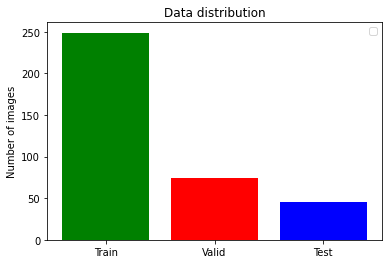

In [15]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

**Add callback for training process**

In [15]:
csv_logger = CSVLogger('./training.log', separator=',', append=False)


callbacks = [
      #keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
      #                         patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=0.0000001, verbose=1),
      keras.callbacks.ModelCheckpoint(filepath = './model_tc.h5',
                              verbose=1, save_best_only=True, save_weights_only = True),
      csv_logger
    ]

# Train model
My best model was trained with 81% accuracy on mean IOU and 65.5% on Dice loss <br>
I will load this pretrained model instead of training again

In [17]:
K.clear_session()

history =  model.fit(training_generator,
                    epochs=200,
                    steps_per_epoch=len(train_ids),
                    callbacks= callbacks,
                    validation_data = valid_generator
                    )  
model.save("./model_x1_tc.h5")

2022-12-28 11:49:56.209033: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-12-28 11:50:07.662098: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


249/249 [==============================] - 502s 2s/step - loss: 0.5575 - accuracy: 0.9691 - mean_io_u: 0.4996 - dice_coef: 0.7422 - dice_coef_tc: 0.5379 - sensitivity: 0.9691 - specificity: 0.9691 - tversky: 0.9646 - auc: 0.9865 - val_loss: 0.6902 - val_accuracy: 0.9807 - val_mean_io_u: 0.3549 - val_dice_coef: 0.6883 - val_dice_coef_tc: 0.4098 - val_sensitivity: 0.9807 - val_specificity: 0.9807 - val_tversky: 0.9804 - val_auc: 0.9865

Epoch 00001: val_loss improved from inf to 0.69019, saving model to ./model_tc.h5
Epoch 2/200
249/249 [==============================] - 394s 2s/step - loss: 0.4246 - accuracy: 0.9838 - mean_io_u: 0.7757 - dice_coef: 0.8167 - dice_coef_tc: 0.6598 - sensitivity: 0.9838 - specificity: 0.9838 - tversky: 0.9836 - auc: 0.9896 - val_loss: 0.6080 - val_accuracy: 0.9843 - val_mean_io_u: 0.8232 - val_dice_coef: 0.7403 - val_dice_coef_tc: 0.4984 - val_sensitivity: 0.9843 - val_specificity: 0.9843 - val_tversky: 0.9843 - val_auc: 0.9868

Epoch 00002: val_loss improv

KeyboardInterrupt: 

In [20]:
import pickle
with open('./trainHistoryDict_tc', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

NameError: name 'history' is not defined

**Visualize the training process**

In [16]:
model = build_resunet((IMG_SIZE,IMG_SIZE,3))
model.compile(loss=focal_tversky_loss,optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics = ['accuracy',keras.metrics.MeanIoU(num_classes=2),dice_coef_tc, sensitivity, specificity,tversky,tf.keras.metrics.AUC()] )
model.load_weights('/kaggle/input/model-and-log/model_tc.h5')

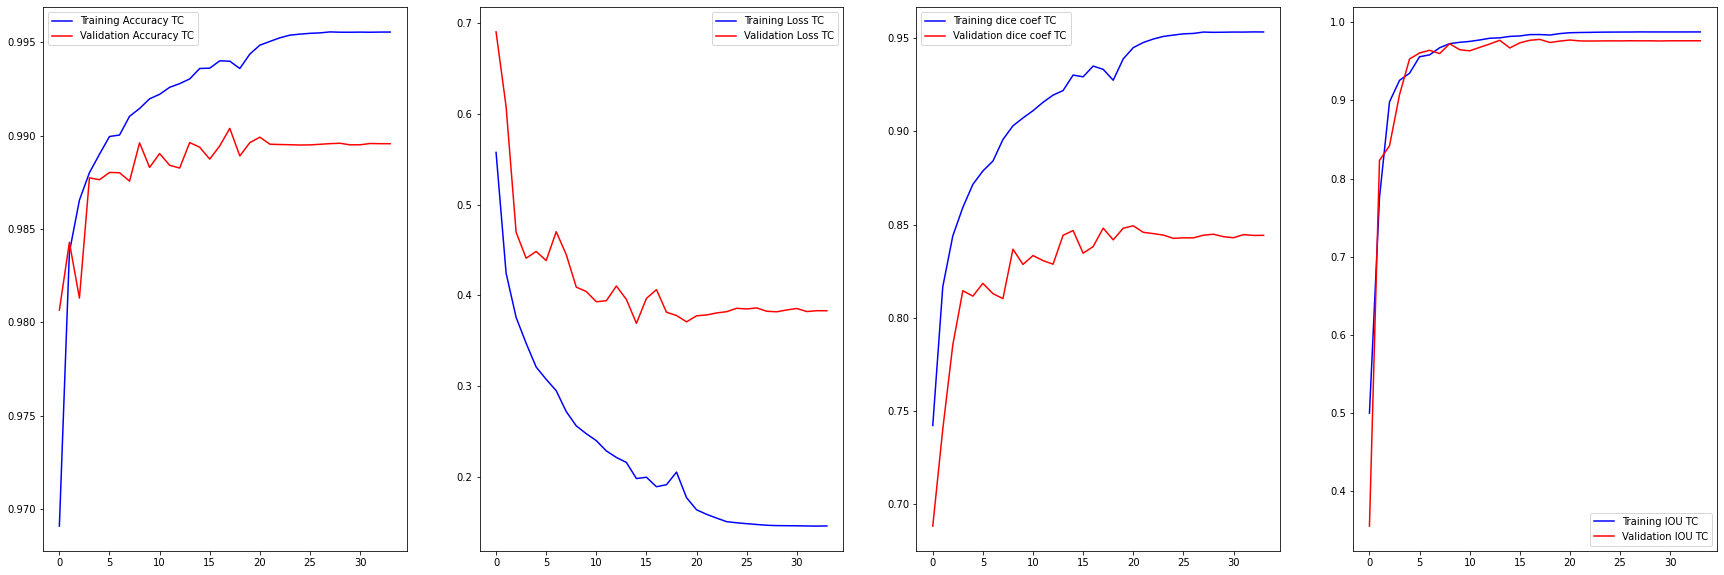

In [4]:
history = pd.read_csv('/kaggle/input/model-and-log/training_log_tc.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(30,10))

ax[0].plot(epoch,acc,'b',label='Training Accuracy TC')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy TC')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss TC')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss TC')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef TC')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef TC')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training IOU TC')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation IOU TC')
ax[3].legend()

plt.show()

# Prediction examples 

In [39]:
# mri type must one of 1) flair 2) t1 3) t1ce 4) t2 ------- or even 5) seg
# returns volume of specified study at `path`
def imageLoader(path):
    image = nib.load(path).get_fdata()
    return np.array(image)


# load nifti file at `path`
# and load each slice with mask from volume
# choose the mri type & resize to `IMG_SIZE`
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] ) 
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[56:184,56:184,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[56:184,56:184,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')
        
#brains_list_test, masks_list_test = loadDataFromDir(VALIDATION_DATASET_PATH, test_directories, "flair", 5)


In [18]:
scaler = MinMaxScaler()

4/4 [==============================] - 0s 44ms/step


<Figure size 2160x2160 with 0 Axes>

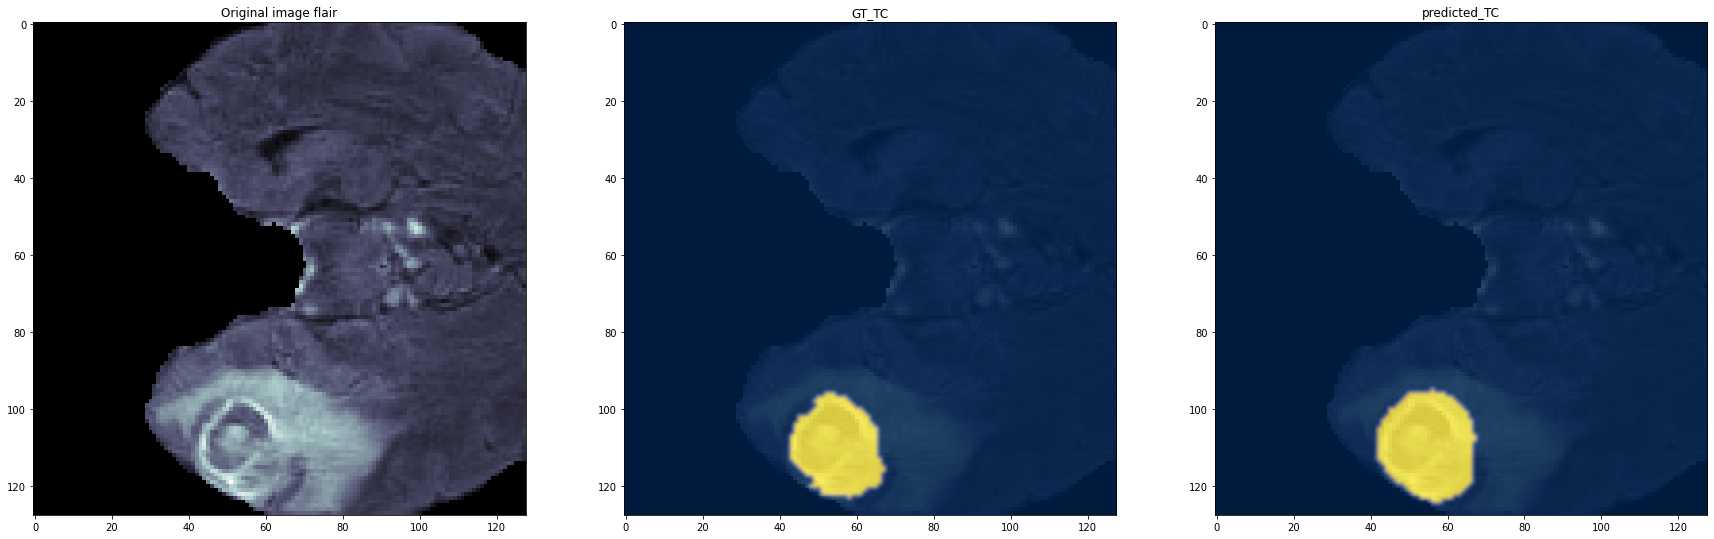

4/4 [==============================] - 0s 43ms/step


<Figure size 2160x2160 with 0 Axes>

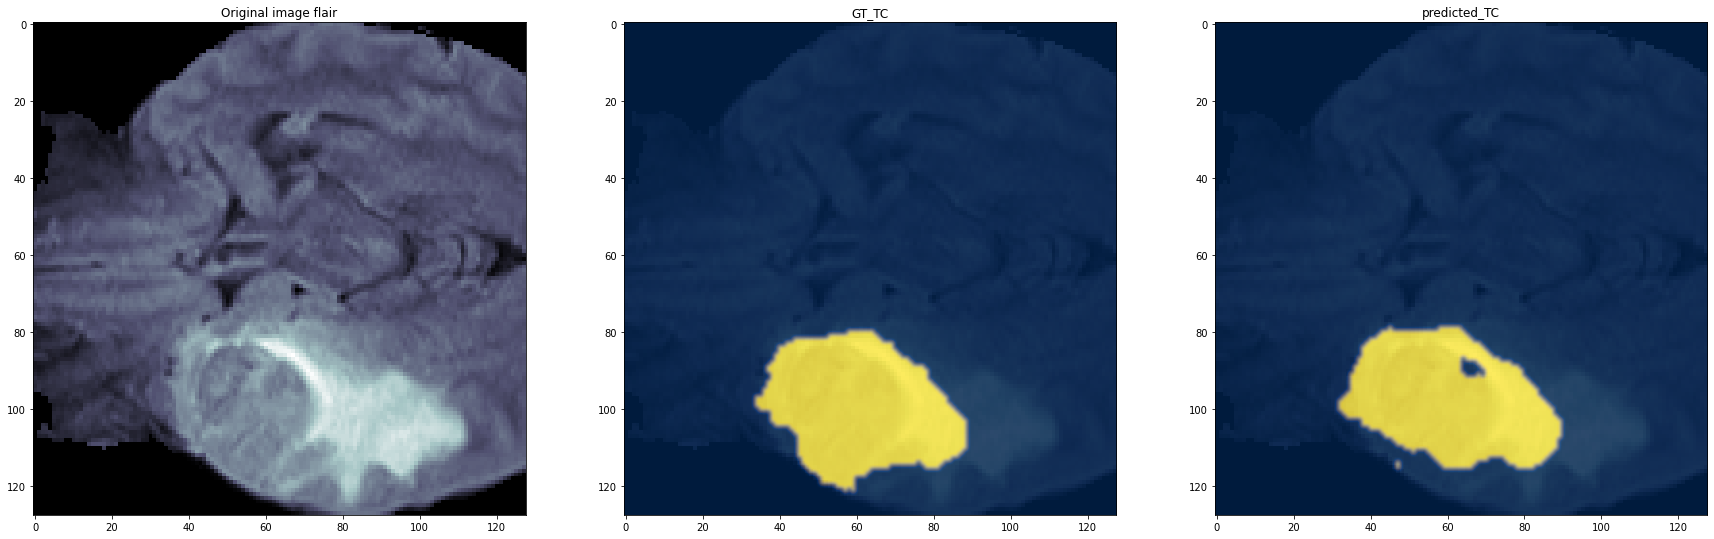

4/4 [==============================] - 0s 43ms/step


<Figure size 2160x2160 with 0 Axes>

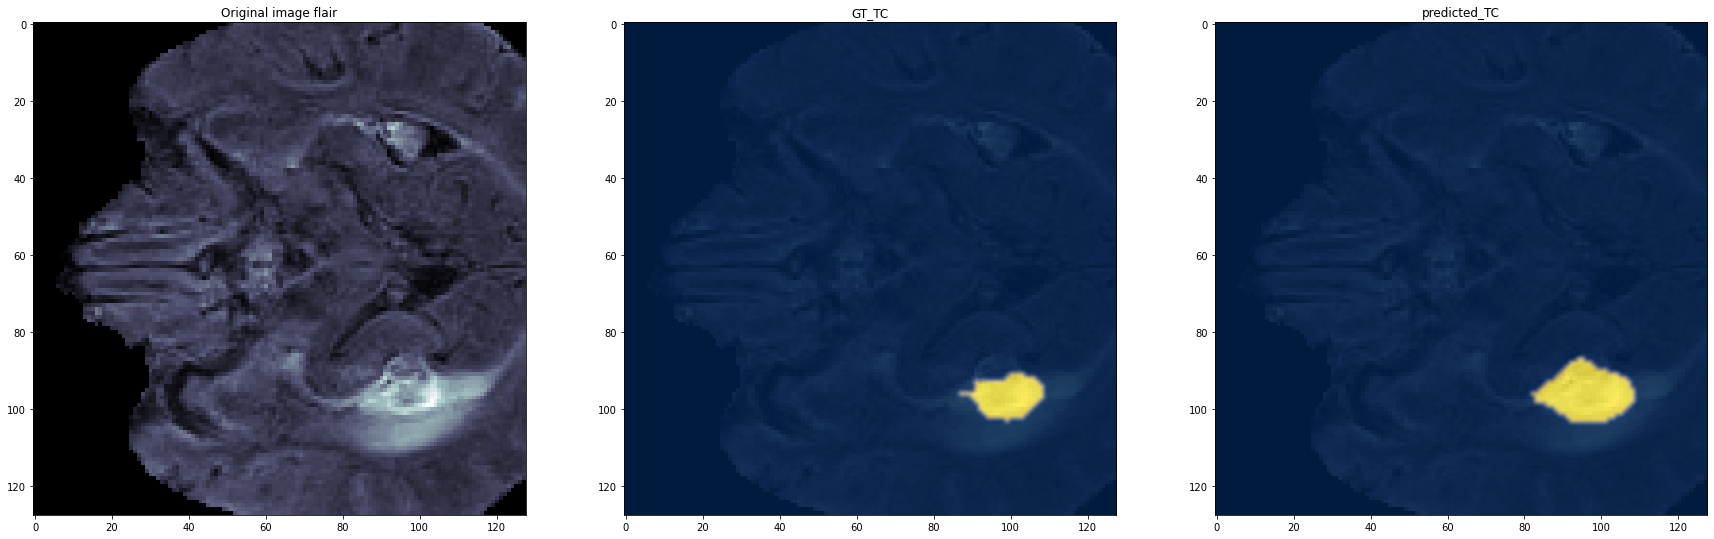

4/4 [==============================] - 0s 42ms/step


<Figure size 2160x2160 with 0 Axes>

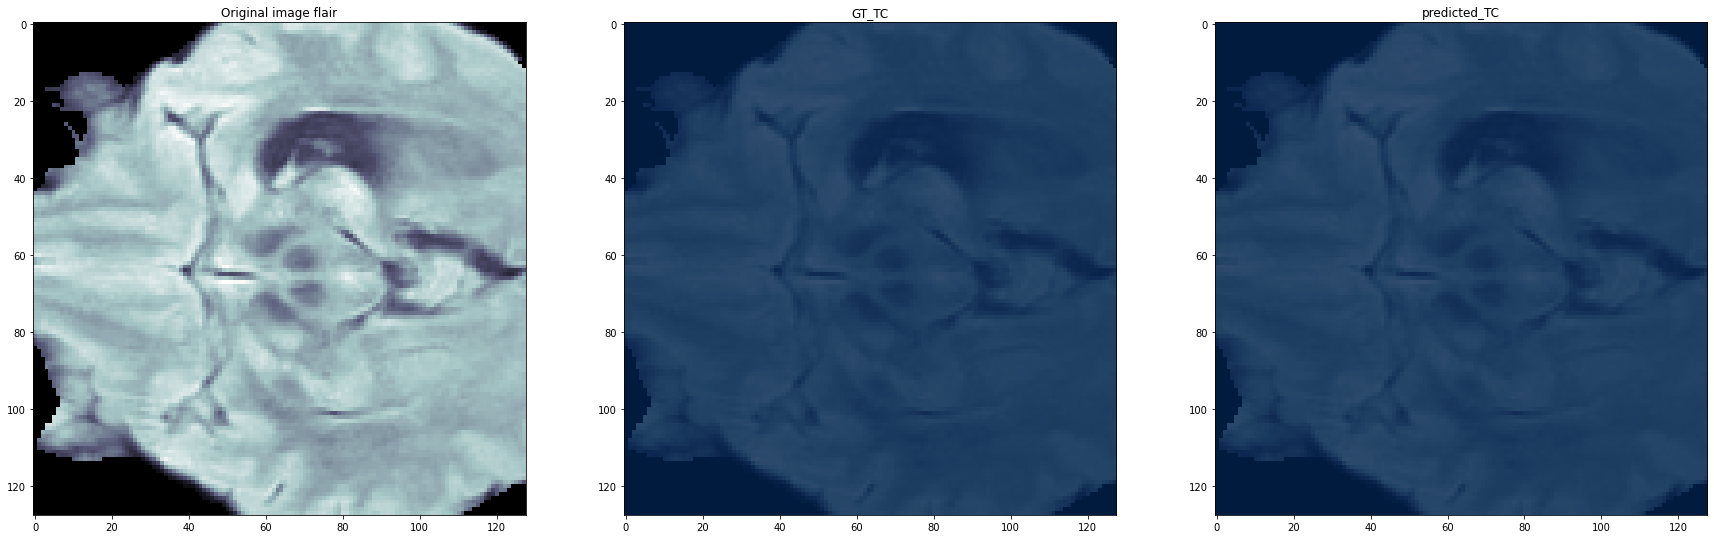

4/4 [==============================] - 0s 42ms/step


<Figure size 2160x2160 with 0 Axes>

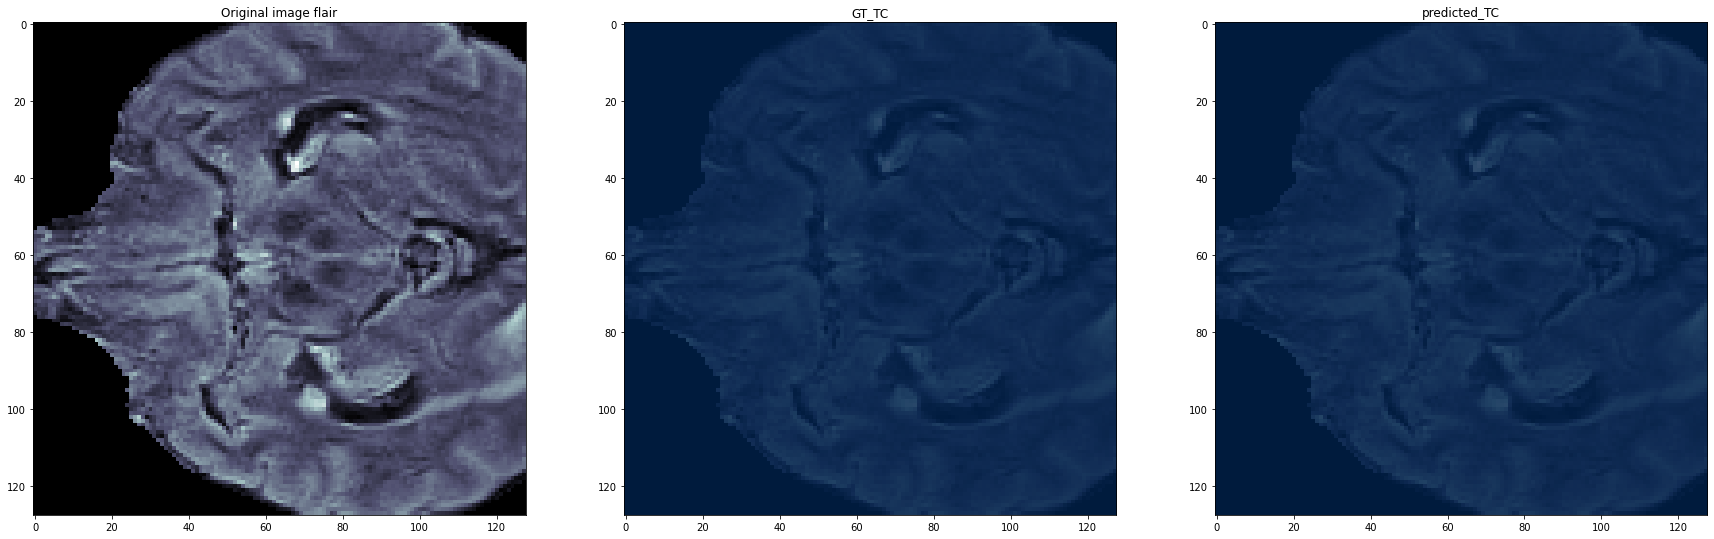

4/4 [==============================] - 0s 42ms/step


<Figure size 2160x2160 with 0 Axes>

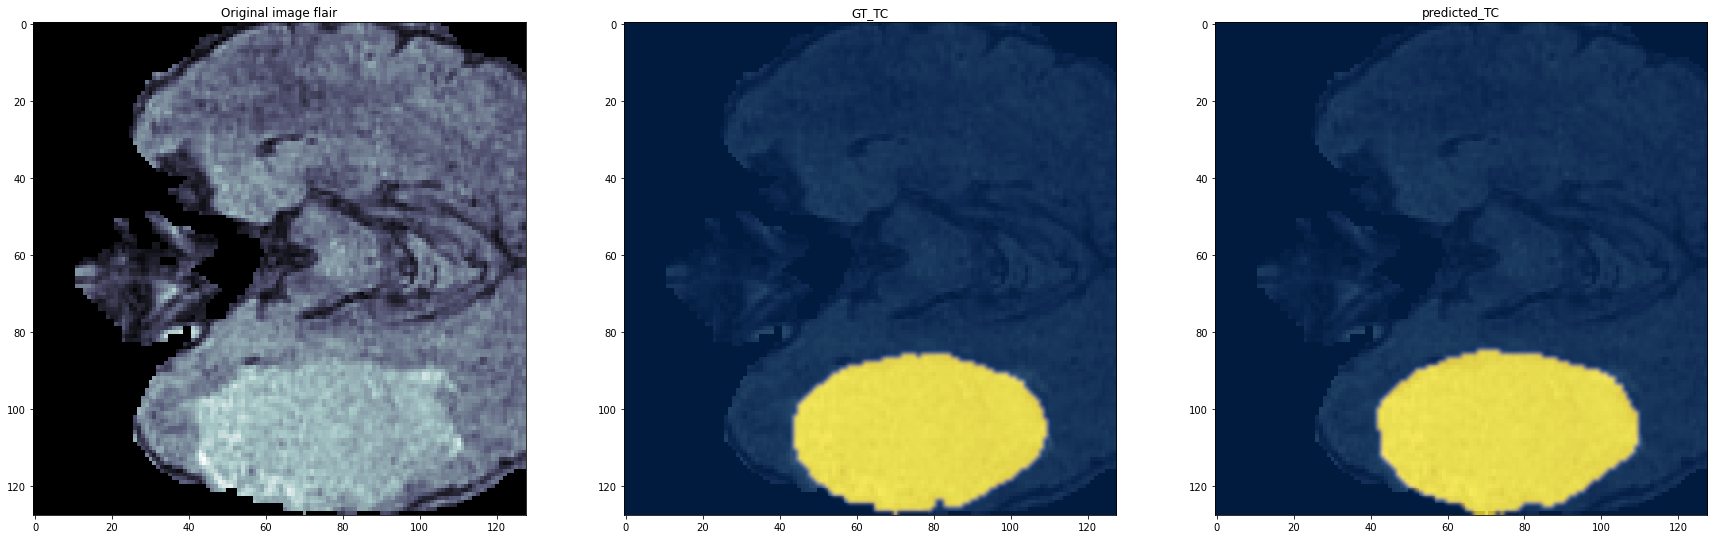

4/4 [==============================] - 0s 42ms/step


<Figure size 2160x2160 with 0 Axes>

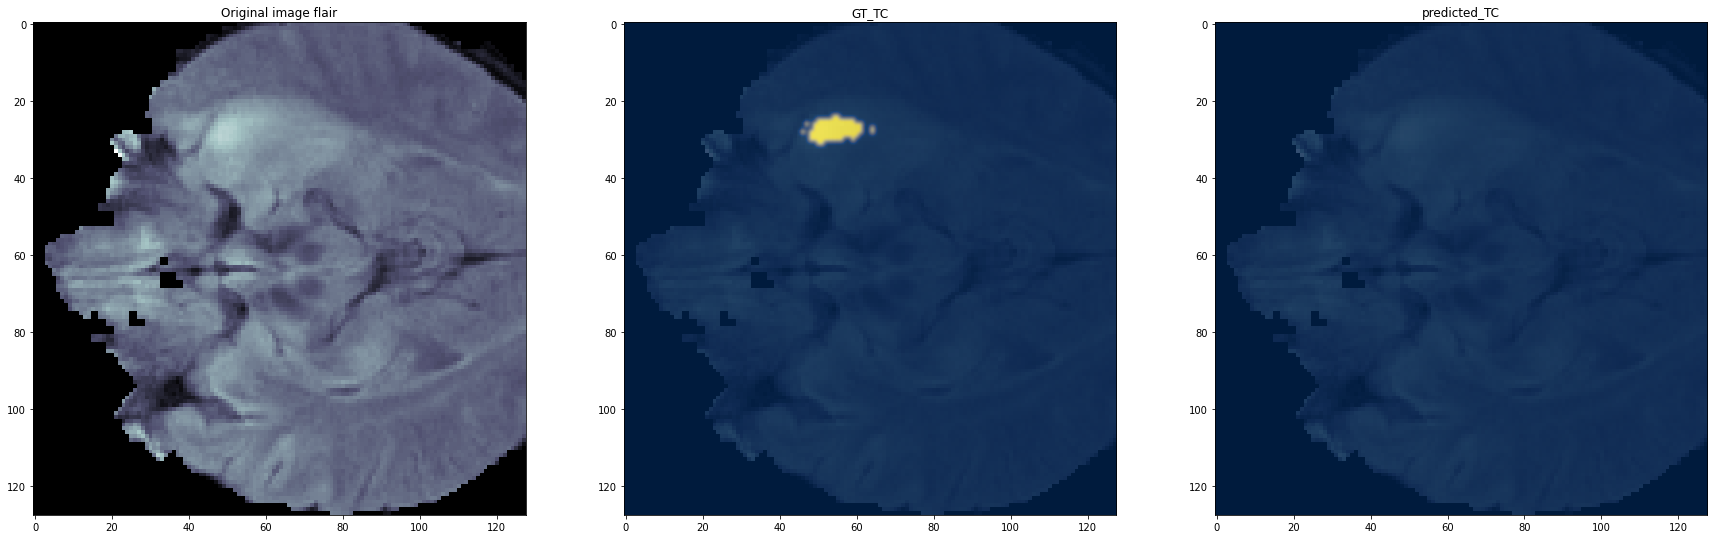

4/4 [==============================] - 0s 42ms/step


<Figure size 2160x2160 with 0 Axes>

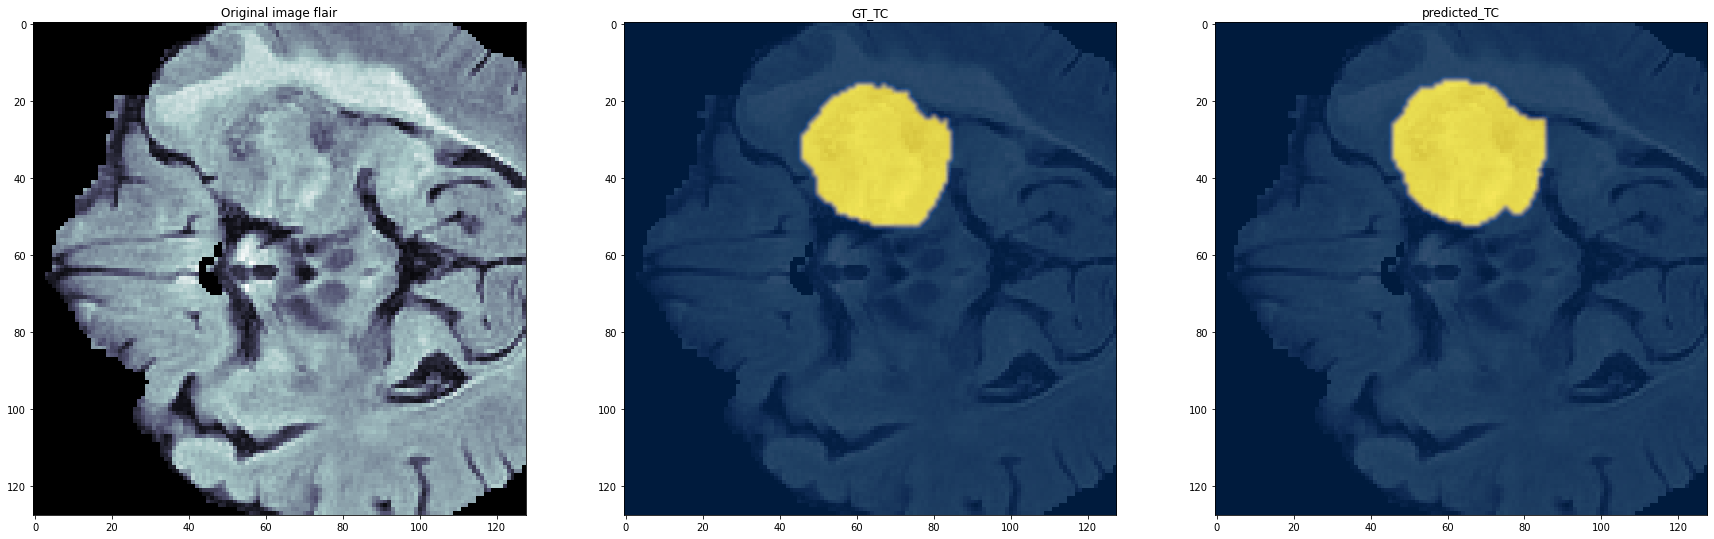

4/4 [==============================] - 0s 42ms/step


<Figure size 2160x2160 with 0 Axes>

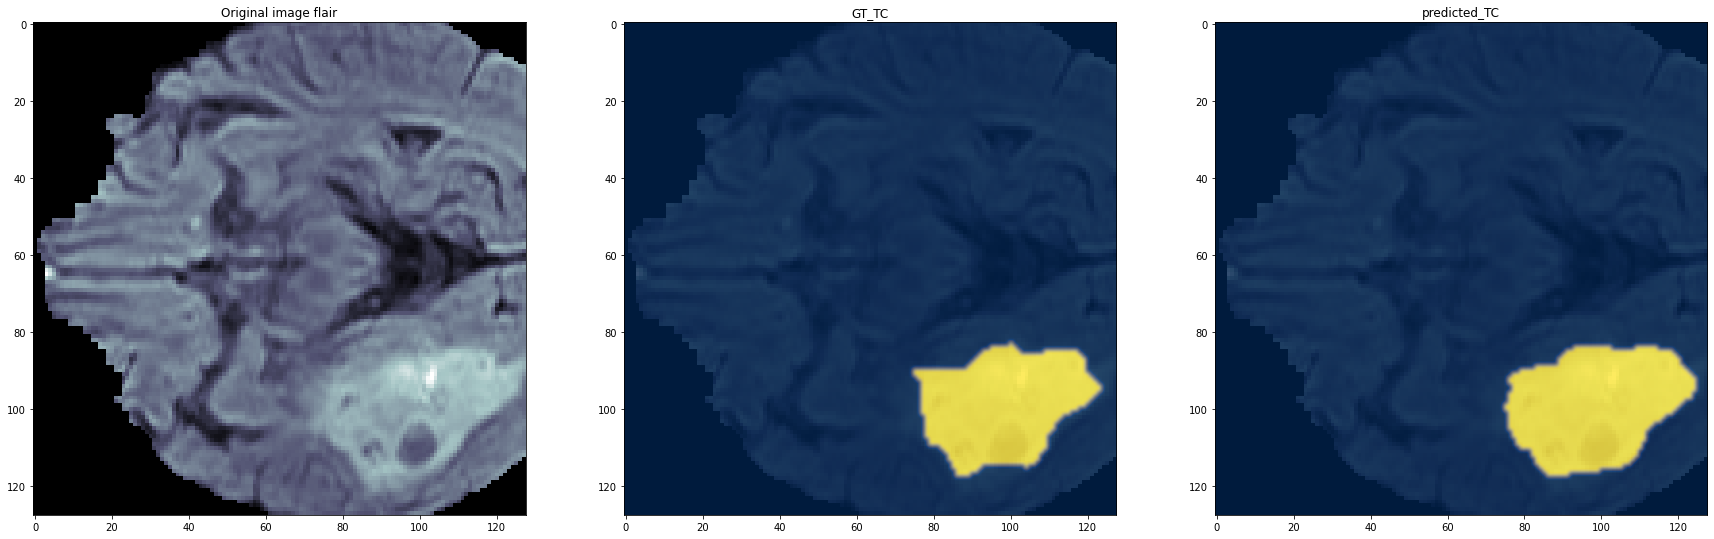

4/4 [==============================] - 0s 42ms/step


<Figure size 2160x2160 with 0 Axes>

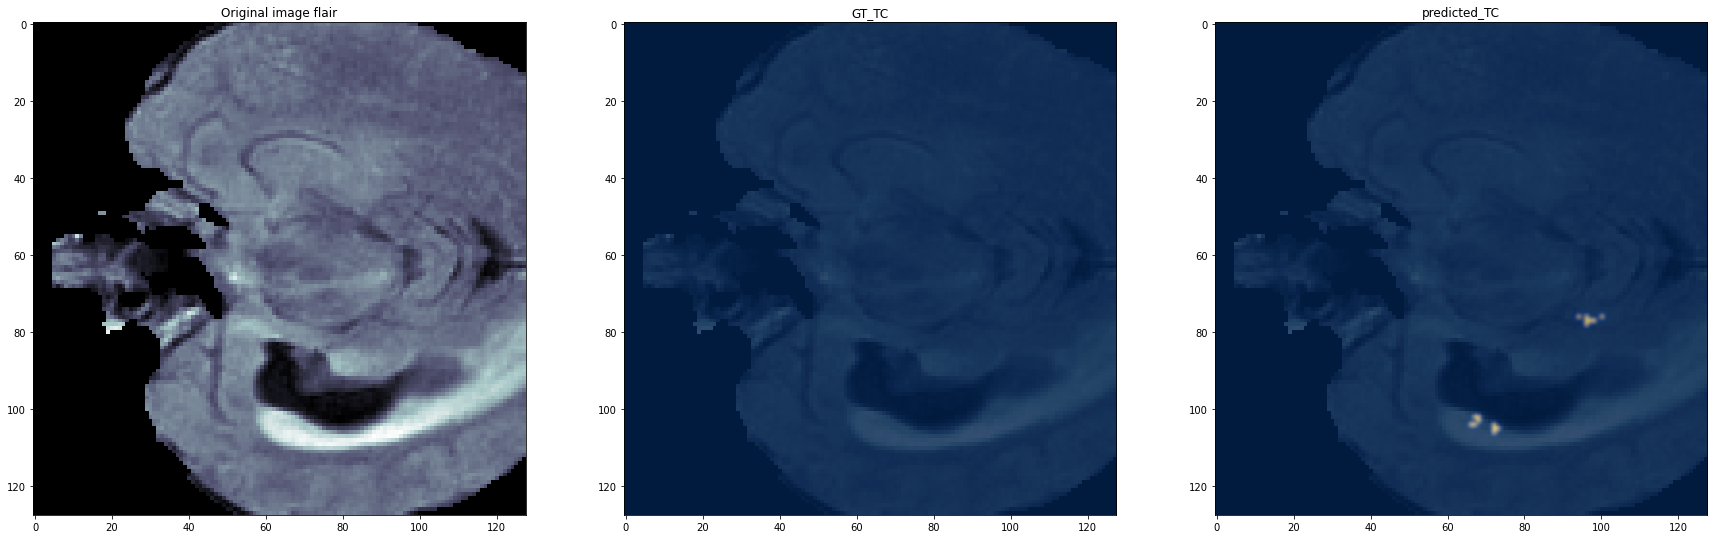

In [20]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 3))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))
    
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()
    shape = flair.shape
    flair = scaler.fit_transform(flair.reshape(-1, flair.shape[-1])).reshape(shape)
    flair = flair[56:184,56:184,:]
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata() 
    shape = ce.shape
    ce = scaler.fit_transform(ce.reshape(-1, ce.shape[-1])).reshape(shape)
    ce = ce[56:184,56:184,:]
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t2.nii');
    t2=nib.load(vol_path).get_fdata() 
    shape = t2.shape
    t2 = scaler.fit_transform(t2.reshape(-1, t2.shape[-1])).reshape(shape)
    t2 = t2[56:184,56:184,:]
    
 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()  

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = ce[:,:,j+VOLUME_START_AT]
        X[j,:,:,1] = flair[:,:,j+VOLUME_START_AT]
        X[j,:,:,2] = t2[:,:,j+VOLUME_START_AT]
        
        
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X,verbose=1)


def showPredictsById(case, start_slice = 35):
    path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()

    et = gt.copy()
    et[et!=4]=0
    et[et!=0]=1

    tc = gt.copy()
    tc[tc == 3]=1
    tc[tc != 1]=0
    tc = tc + et
    
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)
    p = p>0.5

    tumor_core= p[:,:,:,1]
    cmap = 'cividis'
    a = 0.8
    inter = 'bicubic'

    plt.figure(figsize=(30,30))
    f, axarr = plt.subplots(1,3, figsize = (30,30)) 

    for i in range(3): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[56:184,56:184,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="bone", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[56:184,56:184,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="bone")
    axarr[0].title.set_text('Original image flair')
    axarr[1].imshow(tc[56:184,56:184,start_slice+VOLUME_START_AT] , interpolation= inter,cmap = cmap, alpha=a)
    axarr[1].title.set_text('GT_TC')
    axarr[2].imshow(p[start_slice,:,:,1], interpolation=inter,cmap = cmap, alpha=a)
    axarr[2].title.set_text('predicted_TC')
    plt.show()
    
for i in range (10,20):    
    showPredictsById(case=test_ids[i][-3:])



# Evaluation

4/4 [==============================] - 0s 43ms/step


<Figure size 432x288 with 0 Axes>

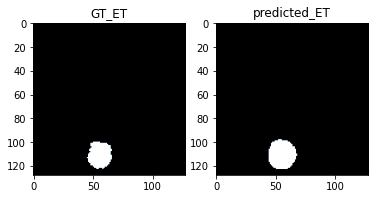

In [27]:
case = case=test_ids[10][-3:]
path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()

et = gt.copy()
et[et!=4]=0
et[et!=0]=1

tc = gt.copy()
tc[tc == 3]=1
tc[tc != 1]=0
tc = tc + et
p = predictByPath(path,case)
p = p>0.5

tumor_core = p[:,:,:,1]


i=50 # slice at
#eval_class = 2 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'



#gt[gt != eval_class] = 1 # use only one class for per class evaluation 

resized_gt = tc[56:184,56:184,i+VOLUME_START_AT]

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(resized_gt, cmap="bone")
axarr[0].title.set_text('GT_ET')
axarr[1].imshow(p[i,:,:,1], cmap="bone")
axarr[1].title.set_text('predicted_ET')
plt.show()

In [21]:
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)

Evaluate on test data
45/45 [==============================] - 51s 1s/step - loss: 0.3468 - accuracy: 0.9932 - mean_io_u: 0.9739 - dice_coef_tc: 0.8565 - sensitivity: 0.9932 - specificity: 0.9932 - tversky: 0.9931 - auc: 0.9949
test loss, test acc: [0.3467814028263092, 0.9931750297546387, 0.9739299416542053, 0.8564696311950684, 0.9931748509407043, 0.9931748509407043, 0.9931264519691467, 0.9949188828468323]


# Survival prediction

Full implementation can be found in my another notebook: https://www.kaggle.com/rastislav/mri-brain-tumor-survival-prediction